# 03b-splicebert_prediction-acceptor.ipynb: Splicing propensity and acceptor site classification using SpliceBERT
Analyses splicing propensity and classifies HBV splice acceptor sites using SpliceBERT, leveraging transformer-based sequence representations to identify predictive features. Includes performance metrics evaluation and splice acceptor site conservation analysis to assess model accuracy and evolutionary constraints, respectively.

In [1]:
import sys
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from tqdm.auto import tqdm
tqdm.pandas()

import logging
logging.basicConfig(level=logging.ERROR, format='%(levelname)s: %(message)s')


scripts_dir = os.path.abspath(os.path.join(os.getcwd(), '../scripts'))

if scripts_dir not in sys.path:
    sys.path.append(scripts_dir)
    
from common import extract_quadruplet_rows, performance_metrics, fasta_to_dataframe, substitute_splice_motifs, get_non_substring_segments, bootstrap_conservation
from splicebert_helpers import predict_with_sliding_window, cal_metric_by_group

Load SpliceBERT pretrained model and a fine-tuned acceptor checkpoint

In [2]:
SPLICEBERT_510 = "../src/SpliceBERT/models/SpliceBERT.510nt/"
tokenizer = AutoTokenizer.from_pretrained(SPLICEBERT_510)

# Acceptor checkpoint
weights = "../src/SpliceBERT/examples/04-splicesite-prediction/output/finetune_splicebert_on_spliceator_GS-GS_1_acceptor_cv/fold0/checkpoint.pt.best_model.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSequenceClassification.from_pretrained(SPLICEBERT_510, num_labels=1).to(device)

# Load the checkpoint dictionary
checkpoint = torch.load(weights, map_location="cpu")
model_state_dict = checkpoint["model"]

# Remove the missing key
if "bert.embeddings.position_ids" in model_state_dict:
    del model_state_dict["bert.embeddings.position_ids"]

model.load_state_dict(model_state_dict, strict=False)
model.eval()

Some weights of the model checkpoint at ../src/SpliceBERT/models/SpliceBERT.510nt/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ..

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(10, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, elem

In [3]:
files = sorted(glob("../data/processed_files/pgrna/pgrna_flank200_*"))

for i in files:
    path, basename = os.path.split(i)
    index = int(basename.split("_")[2])
    
    hbvdb = pd.read_csv(i, sep="\t", header=None)
    hbvdb.columns = ["tid","genotype","length","seq"]

    hbvdb["splicebert_cls"] = hbvdb.seq.progress_apply(lambda x: predict_with_sliding_window(
            x,
            model,
            tokenizer,
            max_len=400,
            stride=1, # Slide by 1 nucleotide
            dnabert_k=None,
            device=device
        ))
    hbvdb.to_pickle(f"{path}/splicebert_hbvdb_{index}.AG.pkl.gz")
    sys.stdout.write(f"\rProgress: {round((index+1)/len(files)*100)}%")
    sys.stdout.flush()

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 3%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 5%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 8%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 11%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 13%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 16%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 18%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 21%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 24%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 26%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 29%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 32%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 34%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 37%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 39%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 42%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 45%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 47%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 50%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 53%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 55%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 58%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 61%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 63%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 66%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 68%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 71%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 74%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 76%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 79%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 82%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 84%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 87%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 89%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 92%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 95%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 97%

  0%|          | 0/101 [00:00<?, ?it/s]

Progress: 100%

Process sliding window output

In [2]:
pred_acceptor = []

for i in glob("../data/processed_files/pgrna/splicebert_hbvdb_[0-9]*.AG.pkl.gz"):
    pred = pd.read_pickle(i)
    pred_acceptor.append(pred)
    
pred_acceptor = pd.concat(pred_acceptor)
pred_acceptor["genotype"] = pred_acceptor["genotype"].str.replace(".fa","")
pred_acceptor['seq'] = pred_acceptor.seq.apply(lambda x: list(x[200:-199]))
pred_acceptor.value_counts(["genotype","length"]).head(20)

genotype  length
C         3639      2084
B         3639      1728
D         3606      1059
A         3645       856
RF        3639       642
E         3636       301
F         3639       252
RF        3606       237
C         3621        40
G         3708        37
H         3639        27
B         3645        17
RF        3645        16
          3636        14
C         3624        14
D         3639         9
C         3597         9
D         3612         8
C         3588         7
RF        3708         7
Name: count, dtype: int64

In [3]:
pred_acceptor = pred_acceptor[(pred_acceptor["length"]==3639)].copy()
pred_acceptor["splicebert_cls"]= pred_acceptor["splicebert_cls"].apply(lambda x: pd.DataFrame(x))
apreds = pd.concat(pred_acceptor["splicebert_cls"].tolist())
apreds[0] = apreds[0].apply(lambda x: x-200)
apreds.columns = ["position","logit","prob"]
apreds.reset_index(drop=True, inplace=True)
apreds["id"] = pred_acceptor["tid"].repeat(3240).reset_index().tid
apreds = pd.merge(apreds, pred_acceptor[["tid","genotype"]].rename(columns={"tid":"id"}))
apreds["base"] = list(np.concatenate(pred_acceptor["seq"].tolist()))

In [4]:
aset = apreds[apreds.genotype.str.contains("B|C|RF|F")].copy()
aset = aset[~aset.genotype.str.contains("RFC")].copy()
asl = aset.groupby(["id","genotype"]).logit.apply(list).reset_index()

Dimensional reduction and clustering

In [8]:
import scanpy as sc

adata = sc.AnnData(np.array(asl.logit.tolist()))
adata.obs["id"] = asl["id"].tolist()
adata.obs["genotype"] = asl["genotype"].tolist()

sc.pp.pca(adata, n_comps=128, random_state=0)
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=50)
sc.tl.umap(adata, random_state=0)
sc.tl.leiden(adata, resolution=0.2)

/tmp/ipykernel_665438/374722927.py:10: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.2)


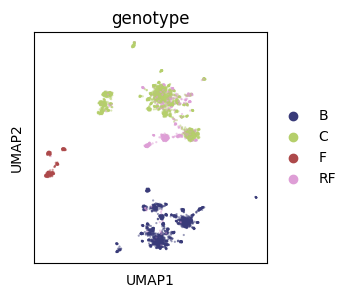

<Figure size 640x480 with 0 Axes>

In [6]:
fig, ax = plt.subplots(figsize=(3, 3))

sc.pl.umap(adata, ax=ax, color="genotype", size=10, palette="tab20b", alpha=0.5)

plt.tight_layout()
fig.savefig("../results/figures/fig4/umap.logit_acceptors.png", bbox_inches='tight', dpi=300)

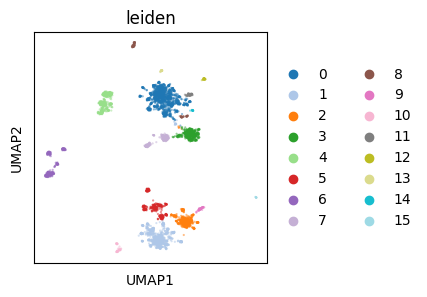

<Figure size 640x480 with 0 Axes>

In [7]:
fig, ax = plt.subplots(figsize=(3, 3))

sc.pl.umap(adata, ax=ax, color="leiden", size=10, palette="tab20", alpha=0.5)

plt.tight_layout()
fig.savefig("../results/figures/fig4/umap.logit_acceptors.leiden.png", bbox_inches='tight', dpi=300)

In [9]:
cal_metric_by_group(adata.obs["genotype"], adata.obs["leiden"], acceptors=adata.obs["genotype"].unique().tolist())

0.5464636264466872

Group SpliceBERT model outputs by splice site usage

In [5]:
x,a,ag,y = extract_quadruplet_rows(aset.reset_index(drop=True), "base", "A", "G", pre_value_any=True)
ag["position"] = ag["position"] + 1

In [6]:
ag.drop_duplicates(["id","base"]).value_counts(["genotype","base"])

genotype  base
C         G       2084
B         G       1728
RF        G        642
F         G        252
Name: count, dtype: int64

In [7]:
cosi_long = pd.read_pickle("../data/processed_files/cosi_long.pkl.gz")
h = cosi_long[cosi_long["Splicing efficiency"]>=0.1].copy()
h["group"] = "Higher usage"

l = cosi_long[cosi_long["Splicing efficiency"]<0.1].copy()
l["group"] = "Lower usage"

hl = pd.concat([h,l])

pos = hl[hl["coSI"]=='$\\theta_3$'].copy()
pos["position"] =  pos["end"]

a = pd.merge(ag, pos[["position","group","Splicing efficiency","Splice site"]], how="left")
a = a.sort_values("Splicing efficiency", ascending=False).drop_duplicates(["position","logit","prob","id","genotype"])
a["group"] = a["group"].fillna("Non-acceptor")

##### Generate control sequences with GT splice sites uniformly substituted with AA

In [9]:
fa = fasta_to_dataframe("../ref/hbvdb/pgrna/pgrna.fa")
fa.columns = ["id","seq"]
fa["id"] = ">" + fa["id"].str.split().str[0]

au = a.dropna()
au = pd.merge(au, fa)
au = au.groupby(["id","seq"])["position"].apply(list).reset_index()
au["seq_sub"] = au.apply(lambda x: substitute_splice_motifs(x["seq"], x["position"], "AG"), axis=1)

fa_flank = pd.read_csv("../ref/hbvdb/pgrna/pgrna_flank200.txt", sep="\t", header=None)[[0,3]]
fa_flank.columns = ["id", "seq_flank"]
au = pd.merge(au, fa_flank)
au["flanks"] = au.apply(lambda x: get_non_substring_segments(x["seq_flank"], x["seq"]), axis=1)
au["seq_sub"] = au.apply(lambda x: x["flanks"][0] + x["seq_sub"] + x["flanks"][1], axis=1)
au = au[["id","seq_sub"]]
au.to_csv("../ref/hbvdb/pgrna/pgrna_flank200_AG-AA.txt", sep="\t", header=None, index=None)

In [10]:
! split -l 200 ../ref/hbvdb/pgrna/pgrna_flank200_AG-AA.txt \
    -d ../data/processed_files/pgrna/pgrna_flank200_AG-AA_

In [11]:
files = sorted(glob("../data/processed_files/pgrna/pgrna_flank200_AG-AA_*"))

for i in files:
    path, basename = os.path.split(i)
    index = int(basename.split("_")[3])
    
    hbvdb_control = pd.read_csv(i, sep="\t", header=None)
    hbvdb_control.columns = ["tid","seq"]

    hbvdb_control["splicebert_cls"] = hbvdb_control.seq.progress_apply(lambda x: predict_with_sliding_window(
            x,
            model,
            tokenizer,
            max_len=400,
            stride=1, # Slide by 1 nucleotide
            dnabert_k=None,
            device=device
        ))
    hbvdb_control.to_pickle(f"{path}/splicebert_hbvdb_control_{index}.AG.pkl.gz")
    sys.stdout.write(f"\rProgress: {round((index+1)/len(files)*100)}%")
    sys.stdout.flush()

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 4%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 8%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 12%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 17%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 21%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 25%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 29%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 33%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 38%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 42%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 46%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 50%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 54%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 58%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 62%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 67%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 71%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 75%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 79%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 83%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 88%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 92%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 96%

  0%|          | 0/106 [00:00<?, ?it/s]

Progress: 100%

Process sliding window output for substitution control

In [8]:
pred_acceptor = []

for i in glob("../data/processed_files/pgrna/splicebert_hbvdb_control_*.AG.pkl.gz"):
    pred = pd.read_pickle(i)
    pred_acceptor.append(pred)
    
pred_acceptor = pd.concat(pred_acceptor)

fa = fasta_to_dataframe("../ref/hbvdb/pgrna/pgrna.fa")
fa["genotype"] = fa.tid.str.split().str[1].str.replace(".fa","")
fa["tid"] = ">" + fa.tid.str.split().str[0]

pred_acceptor = pd.merge(pred_acceptor, fa[["tid","genotype"]])
pred_acceptor["length"] = pred_acceptor.seq.apply(len)
pred_acceptor['seq'] = pred_acceptor.seq.apply(lambda x: list(x[200:-199]))
pred_acceptor.value_counts(["genotype","length"])

genotype  length
C         3639      2084
B         3639      1728
RF        3639       642
F         3639       252
Name: count, dtype: int64

In [9]:
pred_acceptor = pred_acceptor[(pred_acceptor["length"]==3639)].copy()
pred_acceptor["splicebert_cls"]= pred_acceptor["splicebert_cls"].apply(lambda x: pd.DataFrame(x))
apreds = pd.concat(pred_acceptor["splicebert_cls"].tolist())
apreds[0] = apreds[0].apply(lambda x: x-200)
apreds.columns = ["position","logit","prob"]
apreds.reset_index(drop=True, inplace=True)
apreds["id"] = pred_acceptor["tid"].repeat(3240).reset_index().tid
apreds = pd.merge(apreds, pred_acceptor[["tid","genotype"]].rename(columns={"tid":"id"}))
apreds["base"] = list(np.concatenate(pred_acceptor["seq"].tolist()))

In [10]:
aset = apreds[apreds.genotype.str.contains("B|C|RF|F")].copy()
aset = aset[~aset.genotype.str.contains("RFC")].copy()
asl = aset.groupby(["id","genotype"]).logit.apply(list).reset_index()

Dimensional reduction and clustering for substitution control

In [5]:
import scanpy as sc

adata = sc.AnnData(np.array(asl.logit.tolist()))
adata.obs["id"] = asl["id"].tolist()
adata.obs["genotype"] = asl["genotype"].tolist()

sc.pp.pca(adata, n_comps=128, random_state=0)
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=50)
sc.tl.umap(adata, random_state=0)
sc.tl.leiden(adata, resolution=0.2)

/tmp/ipykernel_4043411/374722927.py:10: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.2)


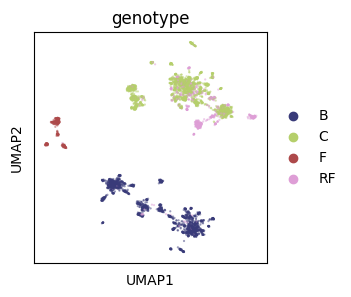

<Figure size 640x480 with 0 Axes>

In [6]:
fig, ax = plt.subplots(figsize=(3, 3))

sc.pl.umap(adata, ax=ax, color="genotype", size=10, palette="tab20b", alpha=0.5)

plt.tight_layout()

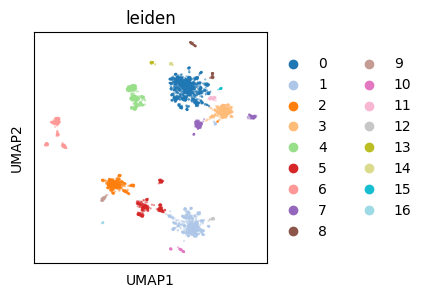

<Figure size 640x480 with 0 Axes>

In [7]:
fig, ax = plt.subplots(figsize=(3, 3))

sc.pl.umap(adata, ax=ax, color="leiden", size=10, palette="tab20", alpha=0.5)

plt.tight_layout()

Note: The observed separation may arise from general genomic sequence context as substitution controls also show distinct clusters as original sequences.

Visualise SpliceBERT model outputs by splice site usage

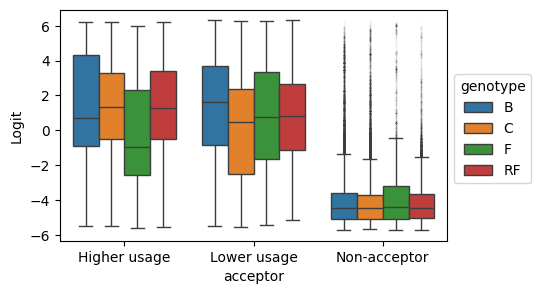

In [14]:
plt.figure(figsize=(5,3))

flierprops = dict(markersize=1, alpha=0.005)
g = sns.boxplot(data=a.sort_values("genotype"), x="group", y="logit", hue="genotype", 
                palette="tab10", flierprops=flierprops,
                order=["Higher usage","Lower usage","Non-acceptor"])#, showfliers=False)
# g = sns.stripplot(data=a, x="group", y="logit", hue="genotype", 
#                   edgecolor='black', linewidth=0.1, alpha=0.01, jitter=0.25, s=1, 
#                   palette="tab10", dodge=True, legend=False)
plt.xlabel("acceptor")
# g.set(xlabel=None)
plt.ylabel("Logit")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 0.75))
plt.savefig("../results/figures/fig5/logit_acceptors.png", bbox_inches='tight', dpi=300)

In [11]:
a[a.base=="G"].drop_duplicates(["Splice site","genotype","position"]).value_counts(["genotype","Splice site","group"])

genotype  Splice site  group       
B         acceptor     Lower usage     12
C         acceptor     Lower usage     12
RF        acceptor     Lower usage     12
F         acceptor     Lower usage     10
C         acceptor     Higher usage     6
B         acceptor     Higher usage     5
F         acceptor     Higher usage     5
RF        acceptor     Higher usage     5
Name: count, dtype: int64

In [12]:
a[a.base=="G"].drop_duplicates(["Splice site","genotype","position"]).value_counts(["Splice site","group"])

Splice site  group       
acceptor     Lower usage     46
             Higher usage    21
Name: count, dtype: int64

In [13]:
a[a.base=="G"].drop_duplicates(["Splice site","position"]).value_counts(["Splice site","group"])

Splice site  group       
acceptor     Lower usage     12
             Higher usage     6
Name: count, dtype: int64

In [14]:
a.value_counts("group")

group
Non-acceptor    652160
Lower usage      47042
Higher usage     20220
Name: count, dtype: int64

In [21]:
a.drop_duplicates('id').value_counts("genotype")

genotype
C     2084
B     1728
RF     642
F      252
Name: count, dtype: int64

Conservation of splice acceptor sites vs non-acceptor AG sites

In [12]:
astats = pd.merge(a[["position","group","genotype"]].drop_duplicates(), a.groupby(["position","genotype"]).logit.describe().reset_index())
agcounts = ag.drop_duplicates("id").value_counts("genotype").reset_index()
agcounts.columns = ["genotype","total sequences"]
astats = pd.merge(astats, agcounts, on="genotype")
astats["% Conserved AG sites"] = astats["count"]/astats["total sequences"] *100

In [13]:
astats.value_counts(["genotype", "group"])

genotype  group       
C         Non-acceptor    673
B         Non-acceptor    602
RF        Non-acceptor    524
F         Non-acceptor    329
B         Lower usage      12
C         Lower usage      12
RF        Lower usage      12
F         Lower usage      10
C         Higher usage      6
B         Higher usage      5
F         Higher usage      5
RF        Higher usage      5
Name: count, dtype: int64

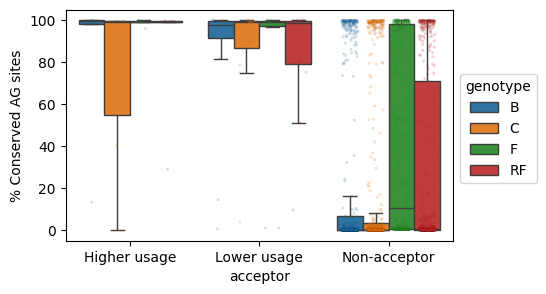

In [16]:
plt.figure(figsize=(5,3))
g = sns.boxplot(data=astats.sort_values("genotype"), x="group", y="% Conserved AG sites", hue="genotype", 
                order=["Higher usage","Lower usage","Non-acceptor"],
                palette="tab10", showfliers=False)
g = sns.stripplot(data=astats.sort_values("genotype"), x="group", y="% Conserved AG sites", hue="genotype", 
                  order=["Higher usage","Lower usage","Non-acceptor"],
                  edgecolor='black', linewidth=0.1, alpha=0.2, jitter=0.25, s=2, 
                  palette="tab10", dodge=True, legend=False)
plt.xlabel("acceptor")
# g.set(xlabel=None)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 0.75))
plt.savefig("../results/figures/fig5/conservation_acceptors.png", bbox_inches='tight', dpi=300)

In [9]:
astats.groupby(["genotype", "group"])["% Conserved AG sites"].median()

genotype  group       
B         Higher usage    99.710648
          Lower usage     97.714120
          Non-acceptor     0.289352
C         Higher usage    99.064299
          Lower usage     99.040307
          Non-acceptor     0.191939
F         Higher usage    99.206349
          Lower usage     99.007937
          Non-acceptor    10.714286
RF        Higher usage    99.376947
          Lower usage     98.909657
          Non-acceptor     0.778816
Name: % Conserved AG sites, dtype: float64

In [10]:
confidence_intervals = []

for i in a.genotype.unique():
    results = bootstrap_conservation(data=a, genotype=i, splice_site="acceptor")
    diffs = np.array(results["Higher usage"]) - np.array(results["Lower usage"])
    ci = np.percentile(diffs, [2.5, 97.5])
    confidence_intervals.append([i, ci[0], ci[1]])
    
confidence_intervals = pd.DataFrame(confidence_intervals)
confidence_intervals.columns = ["genotype","95% CI lower","95% CI upper"]
confidence_intervals

,genotype,95% CI lower,95% CI upper
0,B,-0.077562,0.016859
1,C,-0.141827,0.022917
2,RF,-0.007292,0.058594
3,F,-0.022000,0.192000


Calculate performance metrics for splice acceptor sites

In [15]:
usage = {'Higher usage':1, 'Lower usage':1, 'Non-acceptor':0}

a["label"] = a.group.apply(lambda x: usage[x])

y_true = a["label"].to_numpy()
y_pred = a.logit.to_numpy()

In [16]:
performance_metrics(y_true, y_pred, 0.5)


AUROC: 0.90
AUPRC: 0.60

Predicted binary labels unique values: [0 1]

Metrics at threshold=0.5:
Accuracy: 0.93
F1-Score: 0.60
Precision: 0.65
Recall: 0.56

Classification Report at threshold=0.5:
              precision    recall  f1-score   support

Not Positive       0.96      0.97      0.96    652160
    Positive       0.65      0.56      0.60     67262

    accuracy                           0.93    719422
   macro avg       0.80      0.76      0.78    719422
weighted avg       0.93      0.93      0.93    719422

